In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import scikitplot as skplt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

##  Data Loading

In [3]:
df = pd.read_csv("sensor_dataset.csv")
df.drop_duplicates(subset=['T', 'RH', 'SM', 'LW', 'Class'], keep='first', inplace=True)
df.head()

,Date and Time,LW,SM,T,RH,DP,Class
0,18-03-2021 14:00,Dry,7.2,33.0,30.9,13.6,Healthy
1,18-03-2021 14:30,Dry,7.3,34.2,32.9,15.6,Healthy
2,18-03-2021 15:00,Dry,7.1,34.3,32.7,15.6,Healthy
3,18-03-2021 15:30,Dry,7.2,33.9,33.8,15.7,Healthy
4,18-03-2021 16:00,Dry,7.1,33.6,33.4,15.3,Healthy


In [4]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Missing values:")
print(df.isnull().sum())


Number of rows: 9260
Number of columns: 7
Missing values:
Date and Time       2
LW                  1
SM               3717
T                   2
RH                  2
DP                  2
Class              11
dtype: int64


In [5]:
num_cols = ['T', 'RH', 'SM', 'LW']
cat_cols = ['Class', "LW"]

df['Class'] = df['Class'].map({'Healthy': 0, 'Diseased': 1})
df['LW'] = df['LW'].map({'Dry': 0, 'Wet': 1 , "Moist": 2})

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

df.dropna(inplace=True)

In [6]:
df['Date and Time'] = pd.to_datetime(df['Date and Time'])
df['Year'] = df['Date and Time'].dt.year
df['Month'] = df['Date and Time'].dt.month
df['Day'] = df['Date and Time'].dt.day
df['Hour'] = df['Date and Time'].dt.hour
df['Minute'] = df['Date and Time'].dt.minute
df['Season'] = (df['Month'] % 12 + 3) // 3  # 1: Winter, 2: Spring, 3: Summer, 4: Fall

In [7]:
df.head(5)

,Date and Time,LW,SM,T,RH,DP,Class,Year,Month,Day,Hour,Minute,Season
0,2021-03-18 14:00:00,0.0,7.2,33.0,30.9,13.6,0.0,2021,3,18,14,0,2
1,2021-03-18 14:30:00,0.0,7.3,34.2,32.9,15.6,0.0,2021,3,18,14,30,2
2,2021-03-18 15:00:00,0.0,7.1,34.3,32.7,15.6,0.0,2021,3,18,15,0,2
3,2021-03-18 15:30:00,0.0,7.2,33.9,33.8,15.7,0.0,2021,3,18,15,30,2
4,2021-03-18 16:00:00,0.0,7.1,33.6,33.4,15.3,0.0,2021,3,18,16,0,2


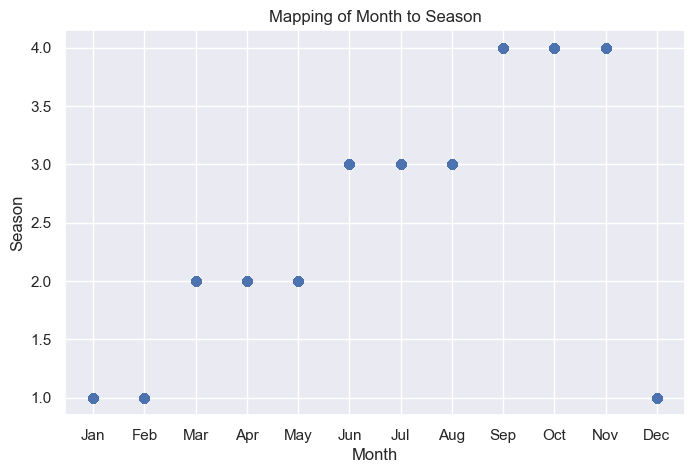

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(df['Month'], df['Season'])
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Season')
plt.title('Mapping of Month to Season')
plt.grid(True)
plt.show()

### Exploratory Data Analysis

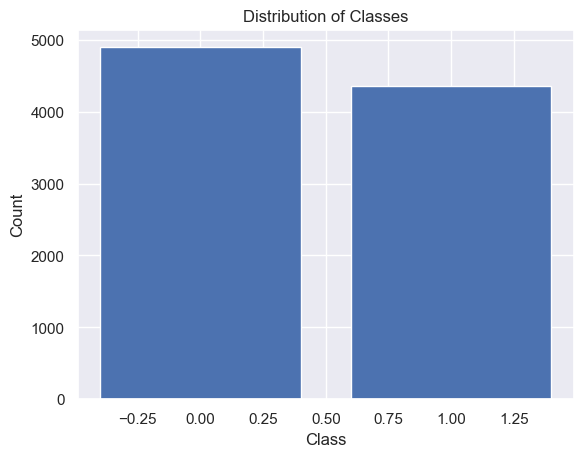

In [9]:
class_counts = df['Class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

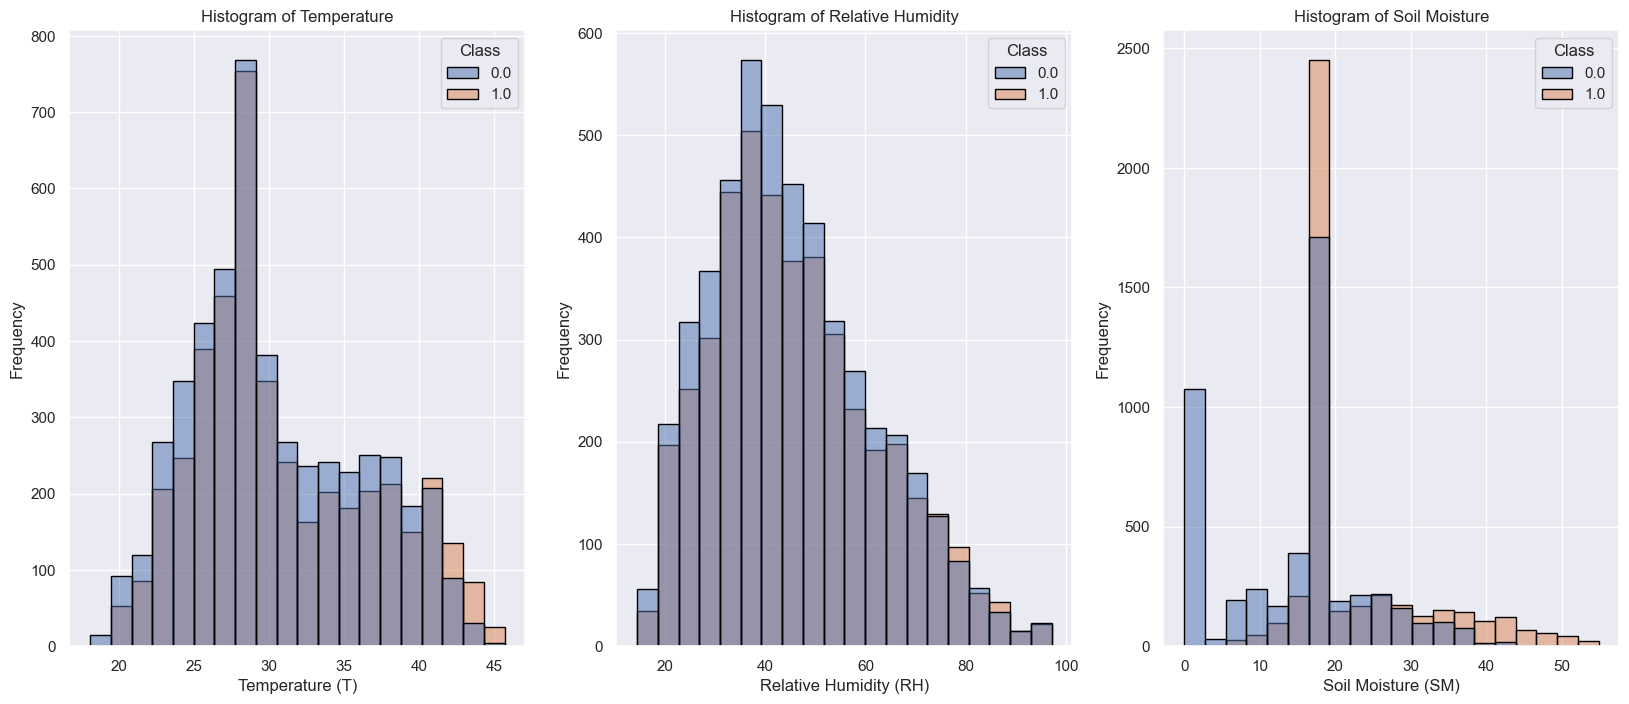

In [10]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
sns.histplot(x = df['T'], bins=20, edgecolor='black', hue= df['Class'])
plt.xlabel('Temperature (T)')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')

plt.subplot(1, 3, 2)
sns.histplot(x = df['RH'], bins= 20, edgecolor = 'black', hue= df['Class'])
plt.xlabel("Relative Humidity (RH)")
plt.ylabel("Frequency")
plt.title("Histogram of Relative Humidity")


plt.subplot(1, 3, 3)
sns.histplot(x = df['SM'], bins= 20, edgecolor = 'black', hue= df['Class'])
plt.xlabel("Soil Moisture (SM)")
plt.ylabel("Frequency")
plt.title("Histogram of Soil Moisture")

plt.show()

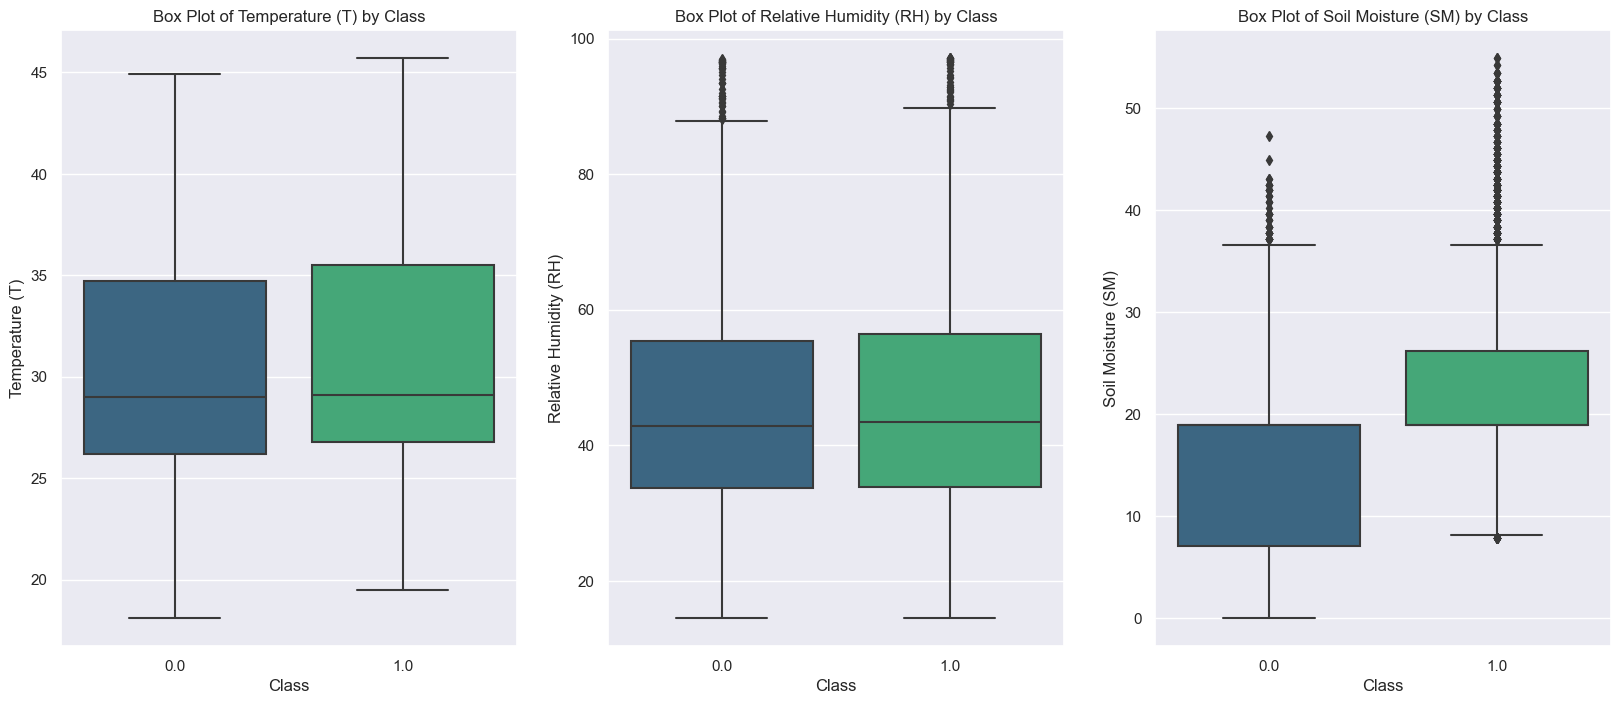

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
sns.boxplot(x='Class', y='T', data=df, palette='viridis')
plt.ylabel('Temperature (T)')
plt.title('Box Plot of Temperature (T) by Class')

plt.subplot(1, 3, 2)
sns.boxplot(x='Class', y='RH', data=df, palette='viridis')
plt.ylabel('Relative Humidity (RH)')
plt.title('Box Plot of Relative Humidity (RH) by Class')


plt.subplot(1, 3, 3)
sns.boxplot(x='Class', y='SM', data=df, palette='viridis')
plt.ylabel('Soil Moisture (SM)')
plt.title('Box Plot of Soil Moisture (SM) by Class')

plt.show()

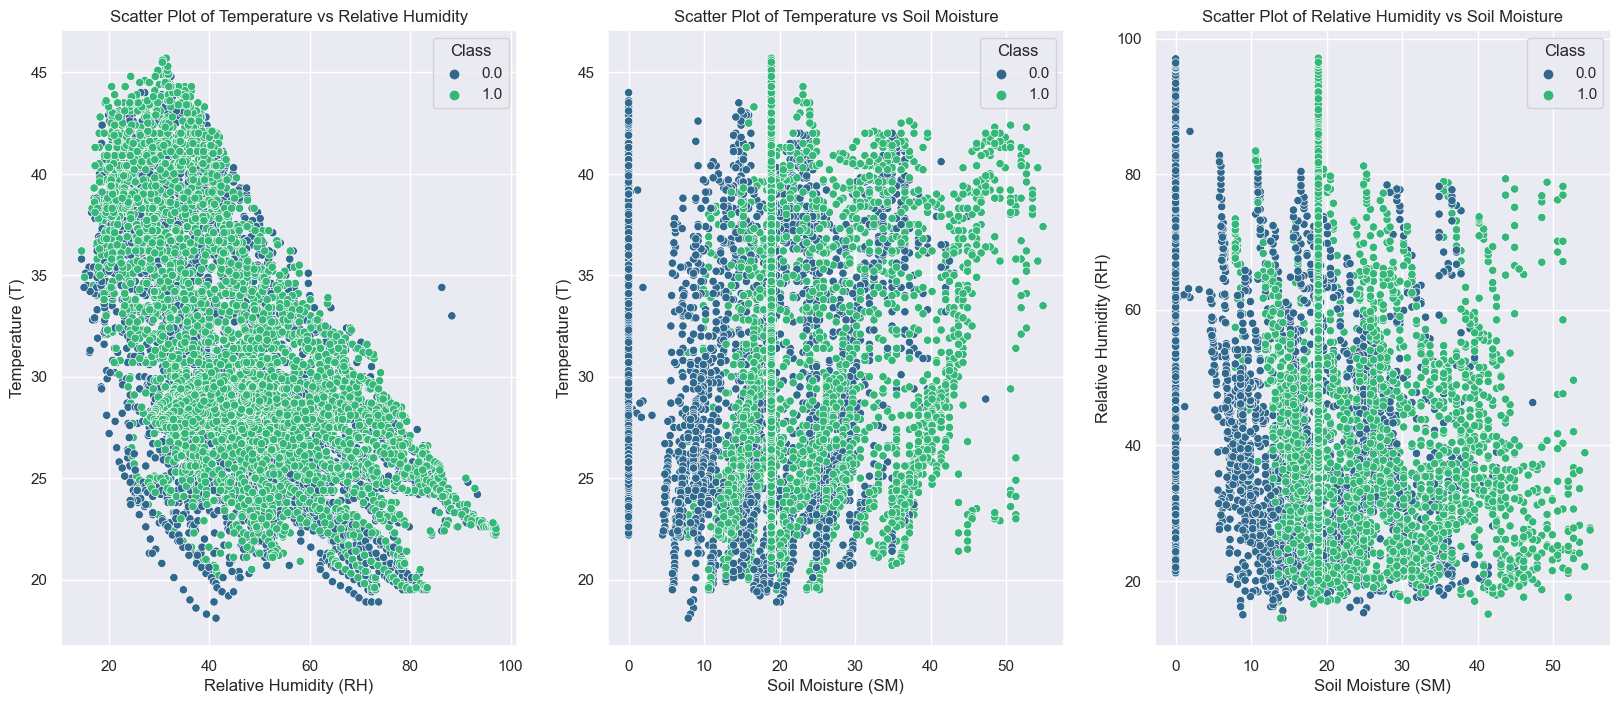

In [12]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
sns.scatterplot(x='RH', y='T', data=df, palette='viridis', hue='Class')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Temperature (T)')
plt.title('Scatter Plot of Temperature vs Relative Humidity')

plt.subplot(1, 3, 2)
sns.scatterplot(x='SM', y='T', data=df, palette='viridis', hue='Class')
plt.xlabel('Soil Moisture (SM)')
plt.ylabel('Temperature (T)')
plt.title('Scatter Plot of Temperature vs Soil Moisture')

plt.subplot(1, 3, 3)
sns.scatterplot(x='SM', y='RH', data=df, palette='viridis', hue='Class')
plt.xlabel('Soil Moisture (SM)')
plt.ylabel('Relative Humidity (RH)')
plt.title('Scatter Plot of Relative Humidity vs Soil Moisture')

plt.show()

In [13]:
fig = px.scatter(df, x='Date and Time', y='T', title='Temperature (T) Over Time')
fig.update_xaxes(title_text='Date and Time')
fig.update_yaxes(title_text='Temperature (T)')
fig.show()

In [14]:
fig = px.scatter(df, x='Date and Time', y='RH', title='Relative Humidity (RH) Over Time')
fig.update_xaxes(title_text='Date and Time')
fig.update_yaxes(title_text='Relative Humidity (RH)')
fig.show()

In [15]:
fig = px.scatter(df, x='Date and Time', y='SM', title='Soil Moisture (SM) Over Time')
fig.update_xaxes(title_text='Date and Time')
fig.update_yaxes(title_text='Soil Moisture(SM)')
fig.show()

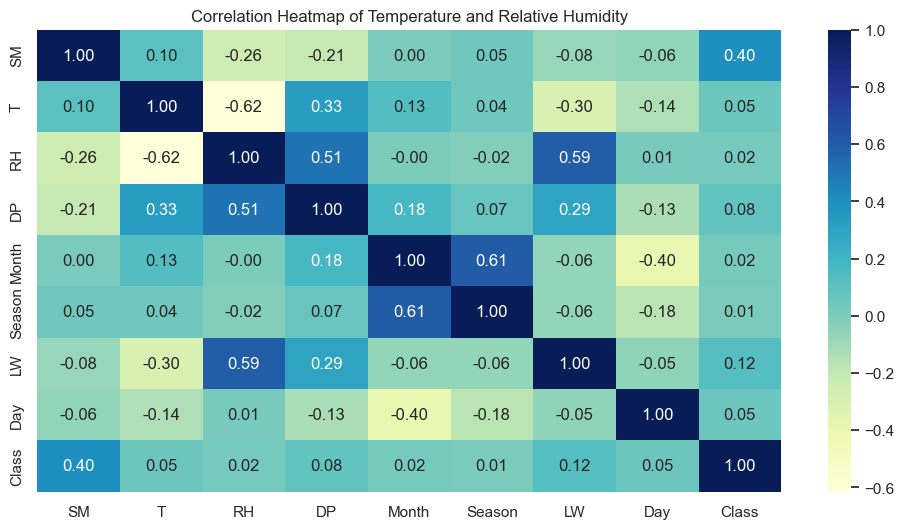

In [16]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[['SM', "T", "RH", "DP", "Month", "Season", "LW", "Day", "Class"]].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Heatmap of Temperature and Relative Humidity')
plt.show()

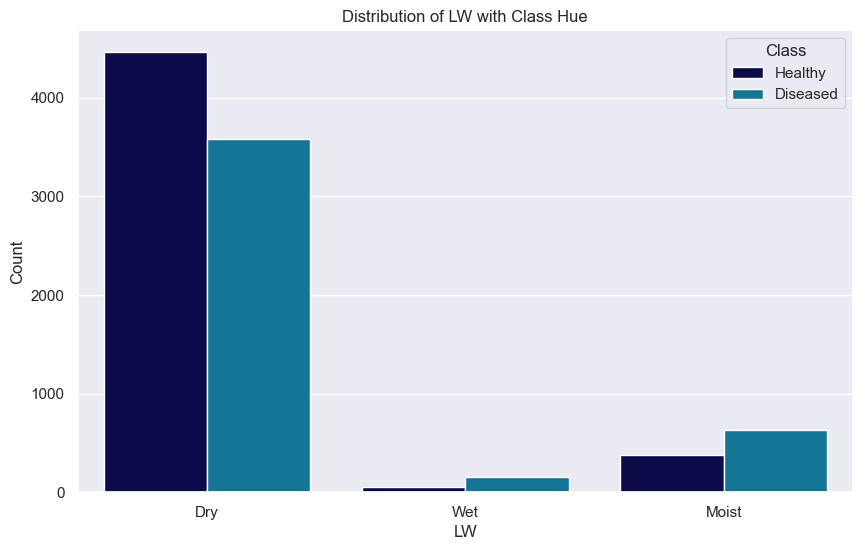

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='LW', hue='Class', data=df, palette='ocean')
plt.xticks([0, 1, 2], ['Dry', 'Wet', 'Moist'])
plt.xlabel('LW')
plt.ylabel('Count')
plt.title('Distribution of LW with Class Hue')
plt.legend(title='Class', labels=['Healthy', 'Diseased'])
plt.show()

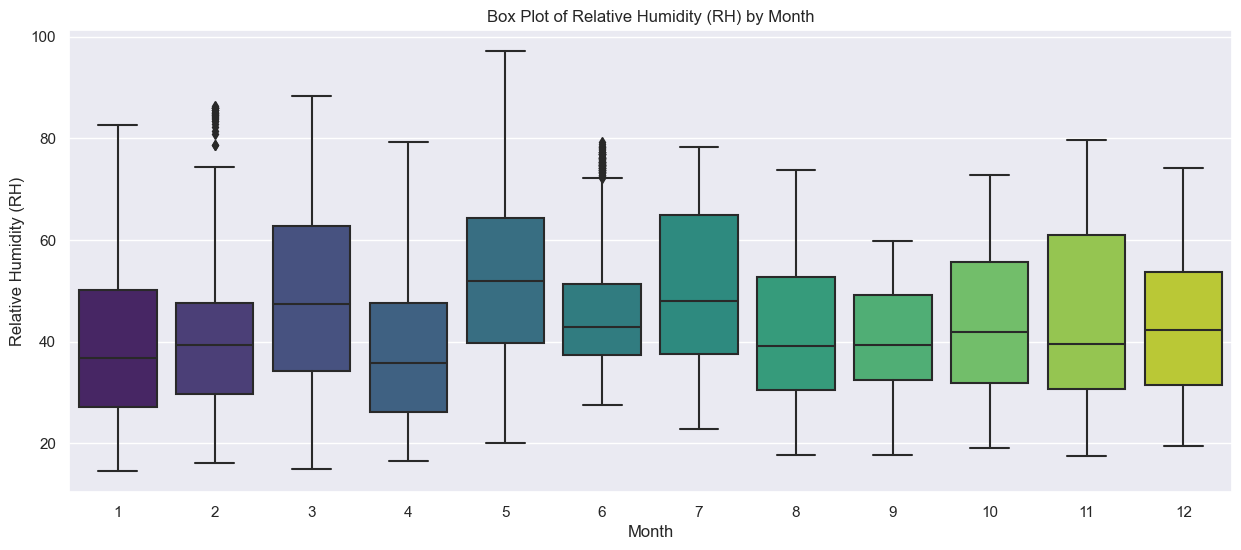

In [18]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='RH', data=df, palette='viridis')
plt.xlabel('Month')
plt.ylabel('Relative Humidity (RH)')
plt.title('Box Plot of Relative Humidity (RH) by Month')
plt.show()

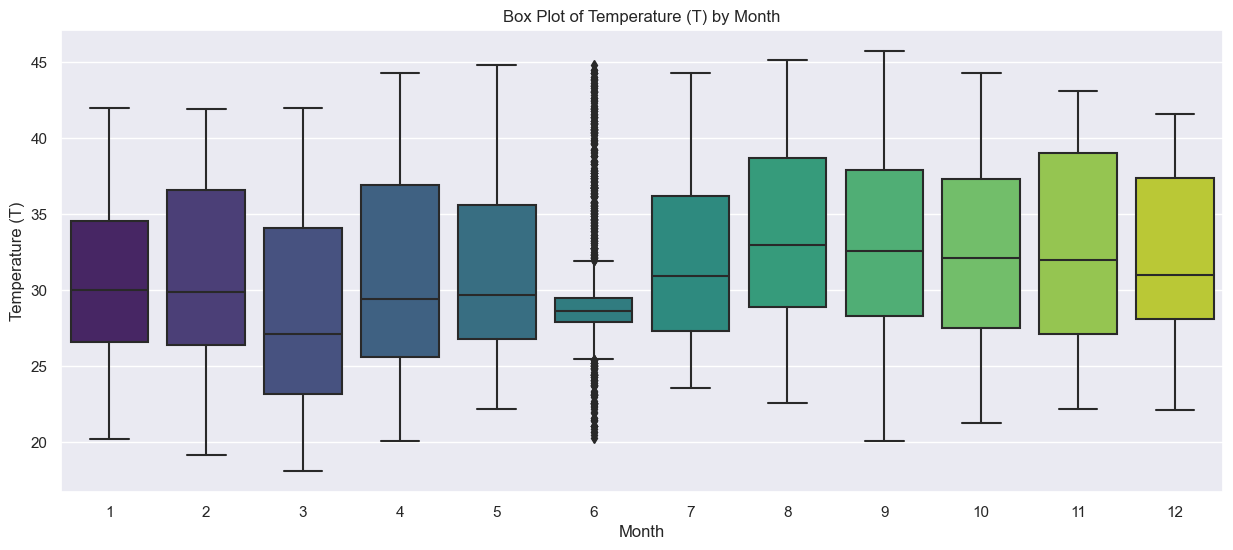

In [19]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='T', data=df, palette='viridis')
plt.xlabel('Month')
plt.ylabel('Temperature (T)')
plt.title('Box Plot of Temperature (T) by Month')
plt.show()

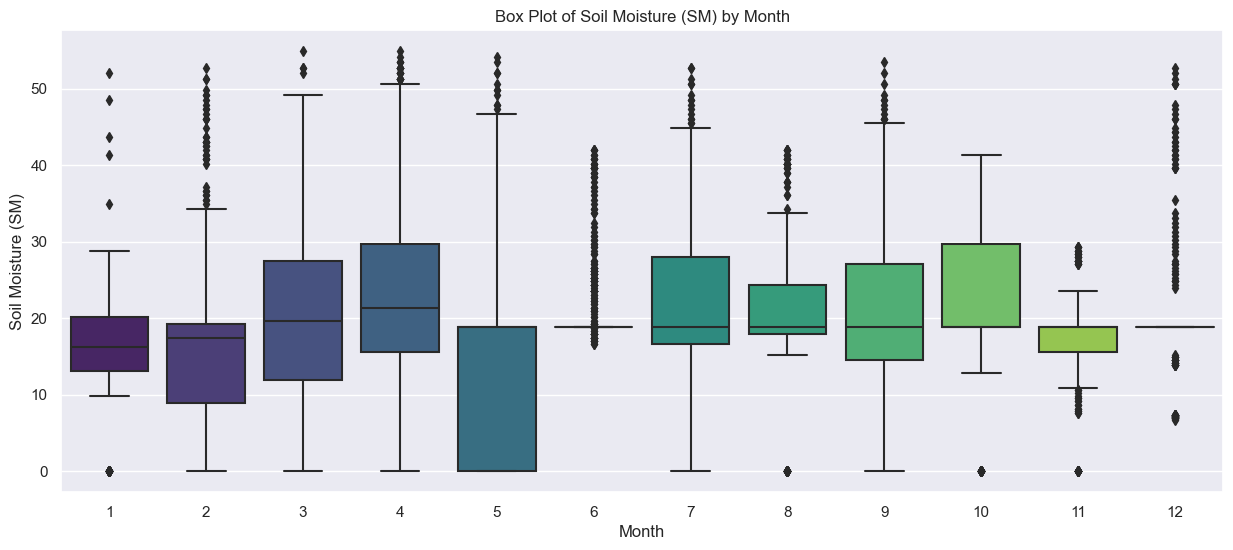

In [20]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='SM', data=df, palette='viridis')
plt.xlabel('Month')
plt.ylabel('Soil Moisture (SM)')
plt.title('Box Plot of Soil Moisture (SM) by Month')
plt.show()

In [21]:
df.drop(['Date and Time', 'Year'], axis=1, inplace=True)

### Modelling

In [22]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
models = {
    'xgboost' : XGBClassifier(),
    'catboost' : CatBoostClassifier(verbose=0),
    'lightgbm' : LGBMClassifier(),
    'random forest' : RandomForestClassifier(),
    'logistic regression': LogisticRegression(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')


xgboost trained
catboost trained
lightgbm trained
random forest trained
logistic regression trained


In [24]:
results = {}

kf = KFold(n_splits= 10)

for name, model in models.items():
    result = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv= kf)
    results[name] = np.mean(result)

In [27]:
for name, result in results.items():
    print("-------\n" + name)
    print(f'ROC score: {round(result, 3)}')

-------
xgboost
ROC score: 0.928
-------
catboost
ROC score: 0.926
-------
lightgbm
ROC score: 0.934
-------
random forest
ROC score: 0.898
-------
logistic regression
ROC score: 0.763


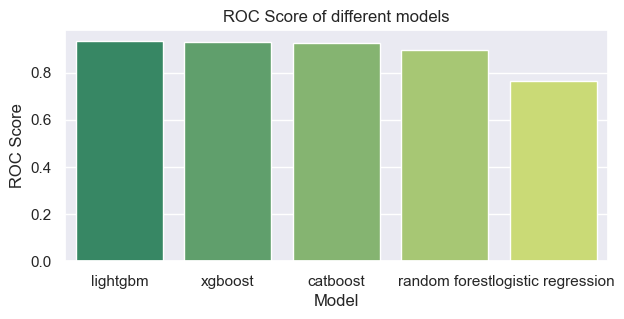

In [30]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'ROC Score'}).sort_values('ROC Score', ascending=False)
plt.figure(figsize = (7, 3))
sns.barplot(x= results_df.index, y = results_df['ROC Score'], palette = 'summer')
plt.xlabel('Model')
plt.ylabel('ROC Score')
plt.title('ROC Score of different models');

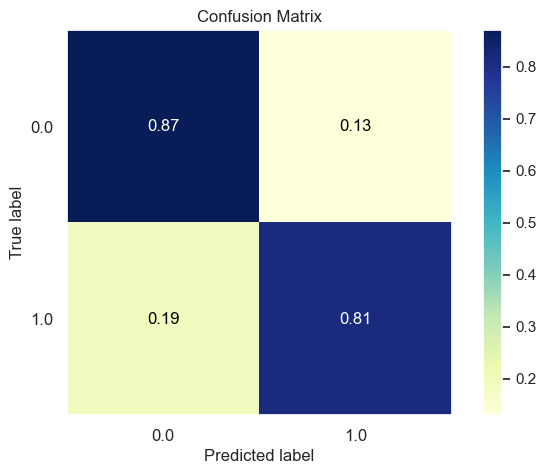

In [35]:
y_pred = models['lightgbm'].predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8, 5), cmap = "YlGnBu")
plt.title('Confusion Matrix')
plt.show()

In [40]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Accuracy Score: 0.8358531317494601
Precision Score: 0.8519813519813519
Recall Score: 0.8050660792951542
F1 Score: 0.8278595696489242
ROC AUC Score: 0.8352660904950346
